In [1]:
import json
import os
import random

import numpy as np
from anytree import PreOrderIter
from matplotlib import pyplot as plt

from QHyper.problems.algorithms.graph_utils import SPTreeNode, get_sp_decomposition_tree, CompositionNode, Composition
from QHyper.problems.algorithms.solver_utils import WorkflowSchedulingSolverDecorator, \
    DecomposedWorkflowSchedulingSolver
from QHyper.problems.workflow_scheduling import Workflow, WorkflowSchedulingOneHot
from QHyper.problems.algorithms.workflow_decomposition import SeriesParallelSplit
from QHyper.problems.algorithms.utils import draw
from QHyper.solvers import Gurobi, solver_from_config

In [2]:
tasks_file = "/home/marcin/Programming/pegasus-instances/epigenomics/chameleon-cloud/epigenomics-chameleon-hep-1seq-100k-001.json"
machines_file = "workflows_data/machines/linear.json"
deadline = 560
workflow = Workflow(tasks_file, machines_file, deadline)
# split = SeriesParallelSplit()
# cpv_before = workflow.critical_path_value
# cpv_after = split.create_sp_workflow(workflow).critical_path_value
# print(cpv_after/cpv_before)

In [3]:
print(workflow.critical_path_value)

552.366656896


(<Figure size 1200x1000 with 1 Axes>, <Axes: >)

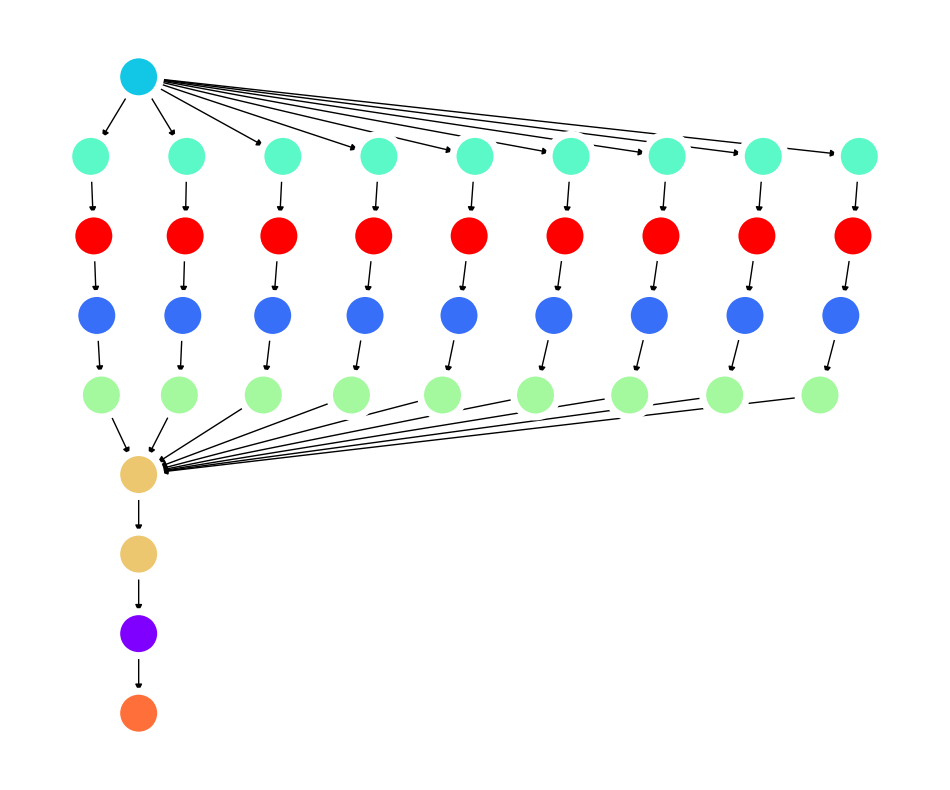

In [4]:
draw(workflow.wf_instance.workflow)

In [5]:
division = SeriesParallelSplit().decompose(workflow, 5)

In [6]:
for w in division.workflows:
    print(w.deadline)
    draw(w.wf_instance.workflow)

KeyboardInterrupt: 

In [7]:
def performance_loss_ratio(tasks_file: str, machines_file: str, deadline: str) -> float:
    workflow = Workflow(tasks_file, machines_file, deadline)
    split = SeriesParallelSplit()
    cpv_before = workflow.critical_path_value
    cpv_after = split.create_sp_workflow(workflow).critical_path_value
    return(cpv_after/cpv_before)

In [8]:
class SpizationMetrics:
    def __init__(self, workflow: Workflow):
        self.workflow = workflow
        self.sp_workflow = SeriesParallelSplit().create_sp_workflow(workflow)
    
    def performance_loss_ratio(self) -> float:
        cpv_before = self.workflow.critical_path_value
        cpv_after = self.sp_workflow.critical_path_value
        return(cpv_after/cpv_before)
    
    def nodes_increase_ratio(self) -> float:
        return len(self.sp_workflow.tasks)/len(self.workflow.tasks)
    
    def series_nodes_influence(self) -> float:
        tree: SPTreeNode = get_sp_decomposition_tree(self.sp_workflow.wf_instance.workflow)
        composition_nodes = [n for n in PreOrderIter(tree) if isinstance(n, CompositionNode)]
        series_nodes = [n for n in composition_nodes if n.operation == Composition.SERIES]
        parallel_nodes = [n for n in composition_nodes if n.operation == Composition.PARALLEL]
        S = sum(map(lambda n: len(n.get_graph_nodes()), series_nodes))
        P = sum(map(lambda n: len(n.get_graph_nodes()), parallel_nodes))
        return S/(S+P)

## SRA search

In [7]:
tasks_file = "workflows_data/workflows/srasearch_22_tasks.json"
machines_file = "workflows_data/machines/3_machines.json"
deadline = 20000
workflow: Workflow = Workflow(tasks_file, machines_file, deadline)
metrics = SpizationMetrics(workflow)
print(metrics.performance_loss_ratio())
print(metrics.nodes_increase_ratio())
print(metrics.series_nodes_influence())

1.0
1.0909090909090908
0.4393939393939394


## Genome

In [12]:
tasks_file = "workflows_data/workflows/1000genome_156_tasks.json"
machines_file = "workflows_data/machines/3_machines.json"
deadline = 20000
workflow: Workflow = Workflow(tasks_file, machines_file, deadline)
metrics = SpizationMetrics(workflow)
print(metrics.performance_loss_ratio())
print(metrics.nodes_increase_ratio())
print(metrics.series_nodes_influence())

1.0
1.0512820512820513
0.3429408891060088


## Cycles

In [6]:
tasks_file = "workflows_data/workflows/cycles_example.json"
machines_file = "workflows_data/machines/3_machines.json"
deadline = 20000
workflow: Workflow = Workflow(tasks_file, machines_file, deadline)
metrics = SpizationMetrics(workflow)
print(metrics.performance_loss_ratio())
print(metrics.nodes_increase_ratio())
print(metrics.series_nodes_influence())

1.000311644450943
1.0176500252143217
0.3198542274052478


In [13]:
len(metrics.sp_workflow.tasks)

2018

## Epigenomics

In [13]:
tasks_file = "workflows_data/workflows/epigenomics-example.json"
machines_file = "workflows_data/machines/3_machines.json"
deadline = 20000
workflow: Workflow = Workflow(tasks_file, machines_file, deadline)
metrics = SpizationMetrics(workflow)
print(metrics.performance_loss_ratio())
print(metrics.nodes_increase_ratio())
print(metrics.series_nodes_influence())

1.0
1.0010172939979654
0.45798647242455776


## Montage

In [9]:
def load_workflows(file, n):
    with open(file, 'r') as f:
        workflows = json.load(f)
    sorted_by_size = sorted([item for item in workflows.items() if item[1] < 1000], key=lambda item: item[1])
    indices = np.linspace(0, len(sorted_by_size) - 1, n, dtype=int)
    return dict([sorted_by_size[i] for i in indices])

In [41]:
print(load_workflows("workflow_sizes/1000genome_sizes.json", 6))

{'/home/marcin/Programming/pegasus-instances/1000genome/chameleon-cloud/1000genome-chameleon-2ch-100k-001.json': 52, '/home/marcin/Programming/pegasus-instances/1000genome/chameleon-cloud/1000genome-chameleon-4ch-250k-001.json': 164, '/home/marcin/Programming/pegasus-instances/1000genome/chameleon-cloud/1000genome-chameleon-12ch-100k-001.json': 312, '/home/marcin/Programming/pegasus-instances/1000genome/chameleon-cloud/1000genome-chameleon-16ch-100k-001.json': 416, '/home/marcin/Programming/pegasus-instances/1000genome/chameleon-cloud/1000genome-chameleon-22ch-100k-001.json': 572, '/home/marcin/Programming/pegasus-instances/1000genome/chameleon-cloud/1000genome-chameleon-22ch-250k-001.json': 902}


In [10]:
def plot_series_nodes_influence_by_size(workflows: dict[str, str]):
    x = list(workflows.values())
    y = [SpizationMetrics(Workflow(t, "workflows_data/machines/3_machines.json", 20000)).series_nodes_influence() for t in workflows.keys()]
    
    fig, axs = plt.subplots(1, 1, figsize=(8,6))
    
    axs.scatter(x, y, color='blue')
    # axs[0].scatter(sizes, execution_times_div, color='orange', label='Division')
    axs.set_xticks(x)
    axs.set_xlabel('Number of vertices')
    axs.set_ylabel('time [s]')
    axs.set_title('Execution time per graph size')
    axs.legend()
    
    # axs[1].scatter(sizes, execution_costs, color='blue', label='No division')
    # axs[1].scatter(sizes, execution_costs_div, color='orange', label='Division')
    # axs[1].set_xticks(sizes)
    # axs[1].set_xlabel('Number of vertices')
    # axs[1].set_ylabel('cost')
    # axs[1].set_title('Execution cost per graph size')
    # axs[1].legend()
    
    plt.tight_layout()
    plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


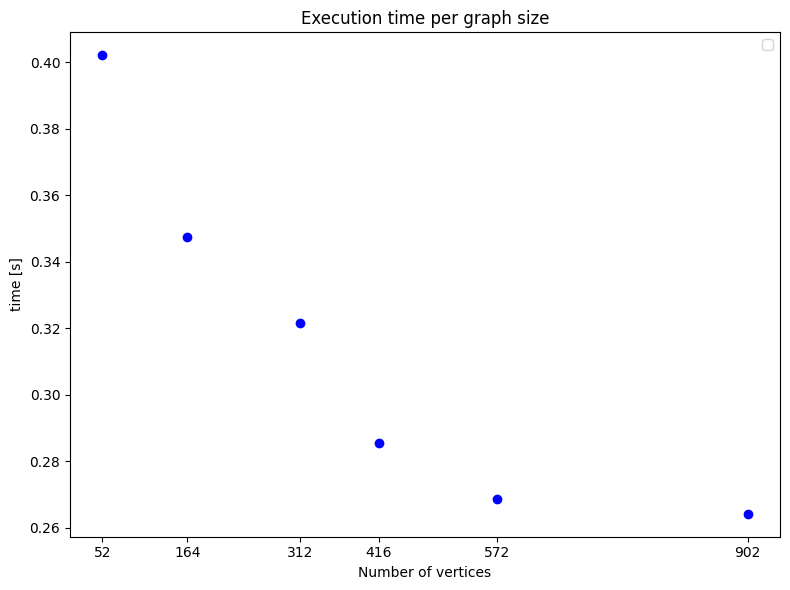

In [10]:
plot_series_nodes_influence_by_size(load_workflows("workflow_sizes/1000genome_sizes.json", 6))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


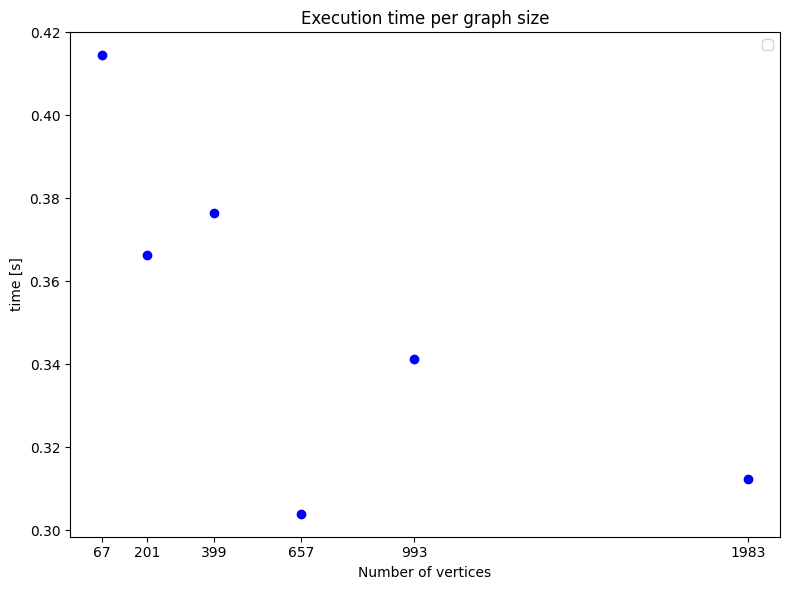

In [11]:
plot_series_nodes_influence_by_size(load_workflows("workflow_sizes/cycles_sizes.json", 6))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


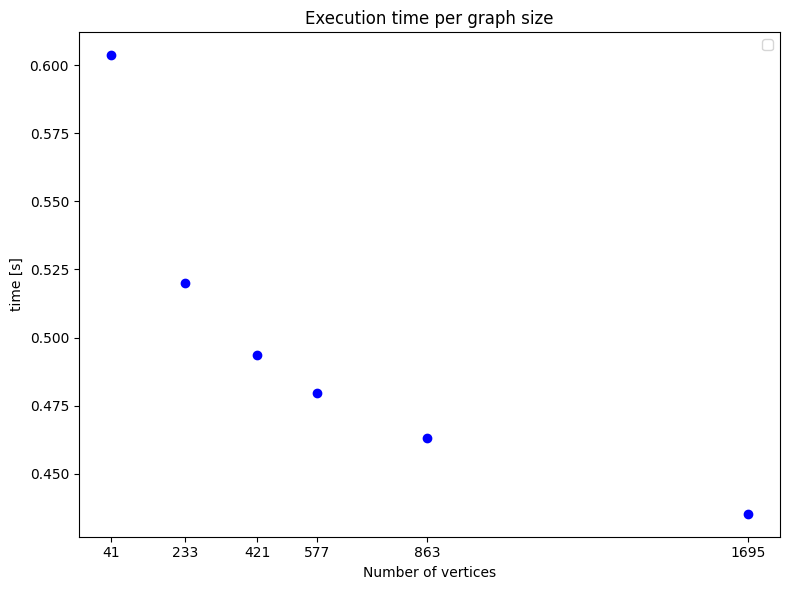

In [13]:
plot_series_nodes_influence_by_size(load_workflows("workflow_sizes/epigenomics_sizes.json", 6))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


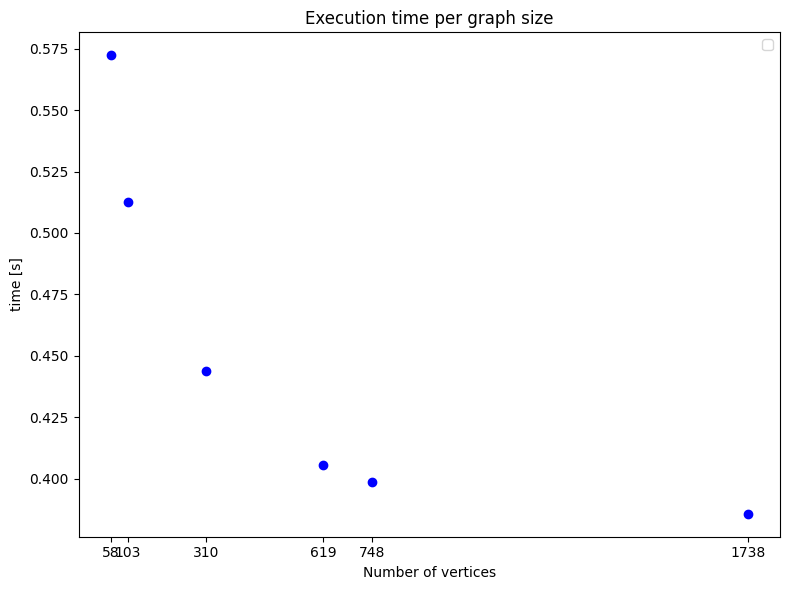

In [12]:
plot_series_nodes_influence_by_size(load_workflows("workflow_sizes/montage_sizes.json", 6))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


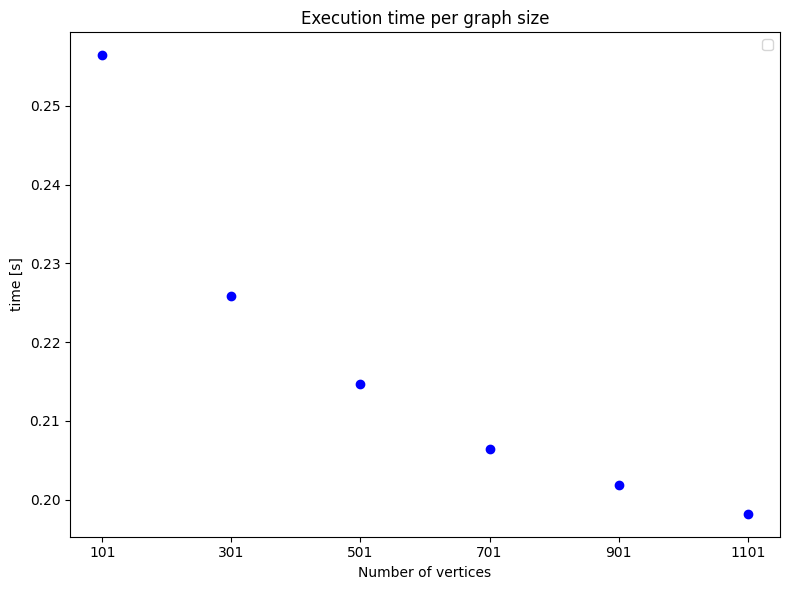

In [14]:
plot_series_nodes_influence_by_size(load_workflows("workflow_sizes/seismology_sizes.json", 6))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


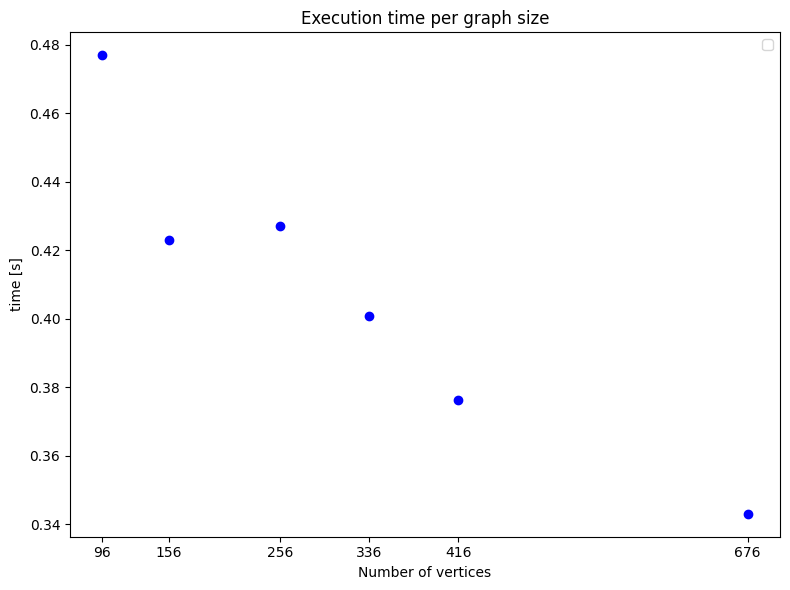

In [15]:
plot_series_nodes_influence_by_size(load_workflows("workflow_sizes/soykb.json", 6))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


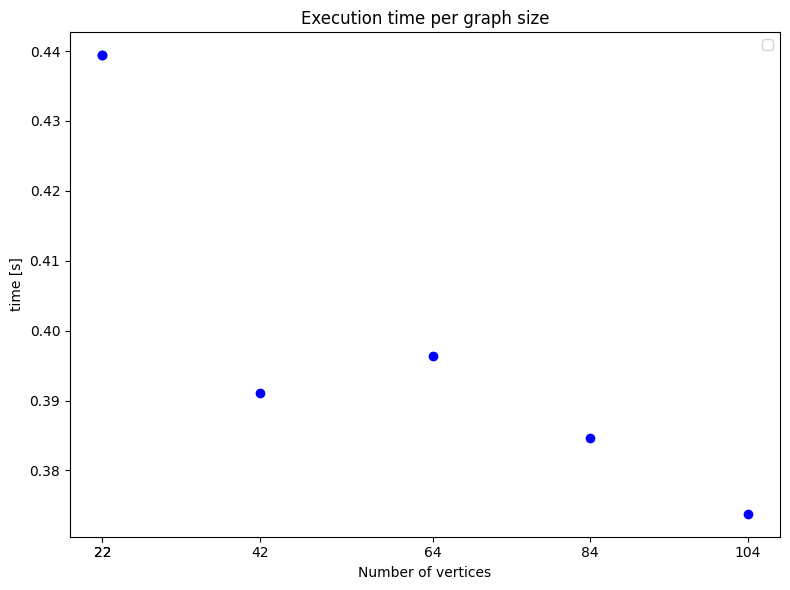

In [16]:
plot_series_nodes_influence_by_size(load_workflows("workflow_sizes/srasearch_sizes.json", 6))

In [11]:
def get_decomposed_solver(tasks_file: str, machines_file: str, deadline: int, max_graph_size: int):
    workflow = Workflow(tasks_file, machines_file, deadline)
    division = SeriesParallelSplit().decompose(workflow, max_graph_size)
    problems = map(lambda w: WorkflowSchedulingOneHot(w), division.workflows)
    solvers = map(lambda p: WorkflowSchedulingSolverDecorator(Gurobi(p)), problems)
    return DecomposedWorkflowSchedulingSolver(list(solvers), division)

def get_solver(tasks_file: str, machines_file: str, deadline: int):
    solver_config = {
        "problem": {
            "type": "workflow_scheduling",
            "encoding": "one-hot",
            "tasks_file": tasks_file,
            "machines_file": machines_file,
            "deadline": deadline,
        },
        "solver": {
            "type": "gurobi",
        }
    }

    return WorkflowSchedulingSolverDecorator(solver_from_config(solver_config))

def measure_cost_overhead(tasks_file, machines_file, subraph_size_divisor=4):
    workflow = Workflow(tasks_file, machines_file, 100000)
    deadline = int(workflow.critical_path_value)
    solver = get_solver(tasks_file, machines_file, deadline)
    sp_solver = get_decomposed_solver(tasks_file, machines_file, deadline, workflow.wf_instance.workflow.number_of_nodes() // subraph_size_divisor)
    workflow_schedule = solver.solve()
    sp_workflow_schedule = sp_solver.solve()
    return sp_workflow_schedule.cost/workflow_schedule.cost

In [13]:
workflows = load_workflows("workflow_sizes/montage_sizes.json", 6)
tasks_files = workflows.keys()
machines_file = "workflows_data/machines/linear.json"
cost_differences = {t: measure_cost_overhead(t, machines_file, 8) for t in tasks_files}

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)
CPU model: Intel(R) Core(TM) i7-7700HQ CPU @ 2.80GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 682 rows, 290 columns and 22970 nonzeros
Model fingerprint: 0x8680b9f4
Variable types: 0 continuous, 290 integer (290 binary)
Coefficient statistics:
  Matrix range     [2e-01, 2e+02]
  Objective range  [1e+00, 1e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+02]
Found heuristic solution: objective 9322.0185600
Presolve removed 227 rows and 100 columns
Presolve time: 0.04s
Presolved: 455 rows, 190 columns, 10375 nonzeros
Found heuristic solution: objective 6532.7846400
Variable types: 0 continuous, 190 integer (190 binary)

Root relaxation: objective 5.803246e+03, 48 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbe

Traceback (most recent call last):
  File "/home/marcin/Programming/QHyper/venv/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3526, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_8683/1582705287.py", line 4, in <module>
    cost_differences = {t: measure_cost_overhead(t, machines_file, 8) for t in tasks_files}
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_8683/1582705287.py", line 4, in <dictcomp>
    cost_differences = {t: measure_cost_overhead(t, machines_file, 8) for t in tasks_files}
                           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_8683/2561236526.py", line 30, in measure_cost_overhead
    sp_workflow_schedule = sp_solver.solve()
                           ^^^^^^^^^^^^^^^^^
  File "/home/marcin/Programming/QHyper/demo/QHyper/problems/algorithms/solver_utils.py", line 64, in solve
    problem: WorkflowSchedu

In [12]:
def plot_cost_difference(cost_differences, workflows):
    x = []
    y = []
    for k, v in cost_differences.items():
        x.append(workflows[k])
        y.append(v)
    
    fig, axs = plt.subplots(1, 1, figsize=(8,6))
    
    axs.scatter(x, y, color='blue')
    # axs[0].scatter(sizes, execution_times_div, color='orange', label='Division')
    axs.set_xticks(x)
    axs.set_xlabel('Number of vertices')
    axs.set_ylabel('Cost difference')
    axs.set_title('Difference in schedule cost between divided and original graph')
    axs.legend()
    
    # axs[1].scatter(sizes, execution_costs, color='blue', label='No division')
    # axs[1].scatter(sizes, execution_costs_div, color='orange', label='Division')
    # axs[1].set_xticks(sizes)
    # axs[1].set_xlabel('Number of vertices')
    # axs[1].set_ylabel('cost')
    # axs[1].set_title('Execution cost per graph size')
    # axs[1].legend()
    
    plt.tight_layout()
    plt.show()

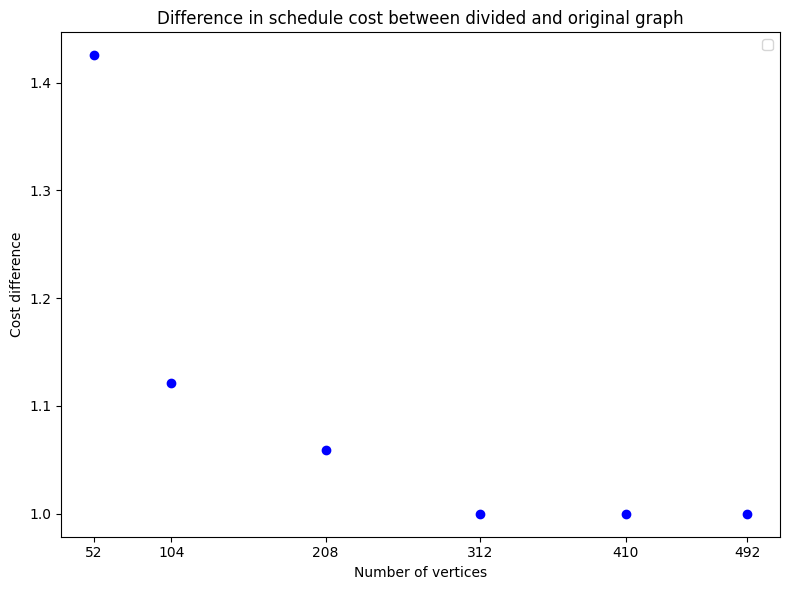

In [20]:
plot_cost_difference(cost_differences, workflows)

In [7]:
workflows = load_workflows("workflow_sizes/montage_sizes.json", 2)
tasks_files = workflows.keys()
machines_file = "workflows_data/machines/linear.json"
cost_differences = {t: measure_cost_overhead(t, machines_file) for t in tasks_files}
plot_cost_difference(cost_differences, workflows)

Set parameter Username
Academic license - for non-commercial use only - expires 2024-11-12
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel(R) Core(TM) i7-7700HQ CPU @ 2.80GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 682 rows, 290 columns and 22970 nonzeros
Model fingerprint: 0x8680b9f4
Variable types: 0 continuous, 290 integer (290 binary)
Coefficient statistics:
  Matrix range     [2e-01, 2e+02]
  Objective range  [1e+00, 1e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+02]
Found heuristic solution: objective 9322.0185600
Presolve removed 227 rows and 100 columns
Presolve time: 0.05s
Presolved: 455 rows, 190 columns, 10375 nonzeros
Found heuristic solution: objective 6532.7846400
Variable types: 0 continuous, 190 integer (190 binary)

Root relaxation: objective 5.803246e+03, 48 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Curren

KeyboardInterrupt: 

In [16]:
tasks_file = "/home/marcin/Programming/pegasus-instances/montage/chameleon-cloud/montage-chameleon-2mass-03d-001.json"
machines_file = "workflows_data/machines/linear.json"
workflow = Workflow(tasks_file, machines_file, 100000)
print(workflow.critical_path_value)

933.8887285760001


In [15]:
workflows

{'/home/marcin/Programming/pegasus-instances/montage/chameleon-cloud/montage-chameleon-2mass-005d-001.json': 58,
 '/home/marcin/Programming/pegasus-instances/montage/chameleon-cloud/montage-chameleon-dss-05d-001.json': 58,
 '/home/marcin/Programming/pegasus-instances/montage/chameleon-cloud/montage-chameleon-dss-075d-001.json': 178,
 '/home/marcin/Programming/pegasus-instances/montage/chameleon-cloud/montage-chameleon-2mass-015d-001.json': 310,
 '/home/marcin/Programming/pegasus-instances/montage/chameleon-cloud/montage-chameleon-2mass-025d-001.json': 619,
 '/home/marcin/Programming/pegasus-instances/montage/chameleon-cloud/montage-chameleon-2mass-03d-001.json': 748}

In [17]:
solver = get_solver(tasks_file, machines_file, 940)

In [58]:
solver.solve()

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel(R) Core(TM) i7-7700HQ CPU @ 2.80GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


Consider calling update less frequently.

Optimize a model with 46744 rows, 2360 columns and 1734680 nonzeros
Model fingerprint: 0x109373c0
Variable types: 0 continuous, 2360 integer (2360 binary)
Coefficient statistics:
  Matrix range     [1e-02, 2e+04]
  Objective range  [6e-02, 1e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+04]
Found heuristic solution: objective 3149611.3759
Presolve removed 39345 rows and 1514 columns
Presolve time: 2.04s
Presolved: 7399 rows, 846 columns, 197702 nonzeros
Found heuristic solution: objective 1930516.8852
Variable types: 0 continuous, 846 integer (846 binary)

Root relaxation: objective 1.904702e+06, 143 iterations, 0.07 seconds (0.09 work units)

    Nodes    |    Current Node    |     Objective Bounds   

WorkflowSchedule(cost=1908336.6905375987, time=10999.794048000003, deadline=11000, machine_assignment={'mProject_ID0000001': 'Machine2', 'mProject_ID0000002': 'Machine2', 'mProject_ID0000003': 'Machine2', 'mProject_ID0000004': 'Machine3', 'mProject_ID0000005': 'Machine2', 'mProject_ID0000006': 'Machine2', 'mProject_ID0000007': 'Machine2', 'mProject_ID0000008': 'Machine3', 'mProject_ID0000009': 'Machine2', 'mProject_ID0000010': 'Machine2', 'mProject_ID0000011': 'Machine2', 'mProject_ID0000012': 'Machine3', 'mProject_ID0000013': 'Machine2', 'mProject_ID0000014': 'Machine2', 'mProject_ID0000015': 'Machine3', 'mProject_ID0000016': 'Machine2', 'mDiffFit_ID0000017': 'Machine1', 'mDiffFit_ID0000018': 'Machine1', 'mDiffFit_ID0000019': 'Machine1', 'mDiffFit_ID0000020': 'Machine2', 'mDiffFit_ID0000021': 'Machine1', 'mDiffFit_ID0000022': 'Machine1', 'mDiffFit_ID0000023': 'Machine1', 'mDiffFit_ID0000024': 'Machine1', 'mDiffFit_ID0000025': 'Machine1', 'mDiffFit_ID0000026': 'Machine1', 'mDiffFit_ID0

In [10]:
tasks_file = "workflows_data/workflows/srasearch_22_tasks.json"
machines_file = "workflows_data/machines/linear.json"
workflow = Workflow(tasks_file, machines_file, 100000)
print(workflow.critical_path_value)

5617.934195328001


In [11]:
solver = get_solver(tasks_file, machines_file, 5600)

KeyboardInterrupt: 

# Experiment 1 - CPV impact

In [27]:
def cpv_increase(workflows: dict):
    cpv_increase_ratios = {}
    for tasks_file in workflows.keys():
        machines_file = "workflows_data/machines/linear.json"
        workflow = Workflow(tasks_file, machines_file, 100000)
        metrics = SpizationMetrics(workflow)
        cpv_increase_ratios[tasks_file] = metrics.performance_loss_ratio()
    return cpv_increase_ratios

In [28]:
genome_cpvs = cpv_increase(load_workflows("workflow_sizes/1000genome_sizes.json", 50))

In [29]:
cycles_cpvs = cpv_increase(load_workflows("workflow_sizes/cycles_sizes.json", 50))

In [30]:
epigenomics_sizes = cpv_increase(load_workflows("workflow_sizes/epigenomics_sizes.json", 50))

In [26]:
montage_sizes = cpv_increase(load_workflows("workflow_sizes/montage_sizes.json", 50))

AttributeError: 'NoneType' object has no attribute 'cpu_speed'

In [31]:
seismology_sizes = cpv_increase(load_workflows("workflow_sizes/seismology_sizes.json", 50))

In [32]:
soykb_sizes = cpv_increase(load_workflows("workflow_sizes/soykb.json", 50))

In [33]:
srasearch_cpvs = cpv_increase(load_workflows("workflow_sizes/srasearch_sizes.json", 50))

In [30]:
print(montage_sizes)

NameError: name 'montage_sizes' is not defined

In [14]:
def save_cpvs(file_path, cpvs):
    with open(file_path, 'w') as file:
        json.dump(cpvs, file, indent=4)

In [32]:
save_cpvs("experiments/cpv_impact/genome_cpv_inc", genome_cpvs)
save_cpvs("experiments/cpv_impact/cycles_cpv_inc", cycles_cpvs)
save_cpvs("experiments/cpv_impact/epigenomics_cpv_inv", epigenomics_sizes)
save_cpvs("experiments/cpv_impact/seismology_cpv_inc", seismology_sizes)
save_cpvs("experiments/cpv_impact/soykb_cpv_inc", soykb_sizes)
save_cpvs("experiments/cpv_impact/srasearch_cpv_inc", srasearch_cpvs)

In [34]:
all_instances = {**genome_cpvs, **cycles_cpvs, **epigenomics_sizes, **seismology_sizes, **soykb_sizes, **srasearch_cpvs}
instances_with_increased_cpv = sorted(filter(lambda kv: kv[1] > 1.0, all_instances.items()), key=lambda item: item[1])

In [35]:
indices = np.linspace(0, len(instances_with_increased_cpv) - 1, 8, dtype=int)
selected_instances = dict([instances_with_increased_cpv[i] for i in indices])

In [40]:
selected_instances

{'/home/marcin/Programming/pegasus-instances/cycles/chameleon-cloud/cycles-chameleon-2l-2c-9p-001.json': 1.0000261067719505,
 '/home/marcin/Programming/pegasus-instances/cycles/chameleon-cloud/cycles-chameleon-5l-3c-9p-001.json': 1.000473754432422,
 '/home/marcin/Programming/pegasus-instances/cycles/chameleon-cloud/cycles-chameleon-2l-1c-9p-001.json': 1.0009038619556285,
 '/home/marcin/Programming/pegasus-instances/cycles/chameleon-cloud/cycles-chameleon-2l-3c-9p-001.json': 1.0035712066449238,
 '/home/marcin/Programming/pegasus-instances/cycles/chameleon-cloud/cycles-chameleon-10l-1c-9p-001.json': 1.004924035360876,
 '/home/marcin/Programming/pegasus-instances/cycles/chameleon-cloud/cycles-chameleon-2l-1c-12p-001.json': 1.0052579735606744,
 '/home/marcin/Programming/pegasus-instances/cycles/chameleon-cloud/cycles-chameleon-5l-1c-9p-001.json': 1.009324499662742,
 '/home/marcin/Programming/pegasus-instances/cycles/chameleon-cloud/cycles-chameleon-1l-2c-9p-001.json': 1.0125665045533179}

In [36]:
cost_increases = {workflow: measure_cost_overhead(workflow, "workflows_data/machines/linear.json", 1/3) for workflow in selected_instances.keys()}

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel(R) Core(TM) i7-7700HQ CPU @ 2.80GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 458 rows, 1330 columns and 5170 nonzeros
Model fingerprint: 0xdffc0895
Variable types: 0 continuous, 1330 integer (1330 binary)
Coefficient statistics:
  Matrix range     [1e-01, 1e+03]
  Objective range  [5e-01, 7e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
Found heuristic solution: objective 308214.75917
Presolve removed 337 rows and 1045 columns
Presolve time: 0.02s
Presolved: 121 rows, 285 columns, 867 nonzeros
Found heuristic solution: objective 151714.01261
Variable types: 0 continuous, 285 integer (285 binary)

Root relaxation: objective 1.402137e+05, 75 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incum

In [47]:
save_cpvs("experiments/cpv_impact/cr_result.json", cost_increases)

In [51]:
save_cpvs("experiments/cpv_impact/selected_instances.json", selected_instances)

In [37]:
def plot_cr_cpv_increase(cost_increases, selected_instances):
    x = []
    y = []
    for workflow, cost_increase in cost_increases.items():
        x.append((selected_instances[workflow] - 1)*100)
        y.append((cost_increase-1)*100)
        
    fig, ax = plt.subplots(1, 1, figsize=(15,6))
    
    ax.scatter(x, y, color='blue')
    ax.set_xticks(x)
    ax.set_xlabel('Relative critical path value increase')
    ax.set_ylabel('Relative schedule cost increase')
    ax.set_title('Influence of the critical path value increase on the schedule cost')
    
    plt.tight_layout()
    plt.show()

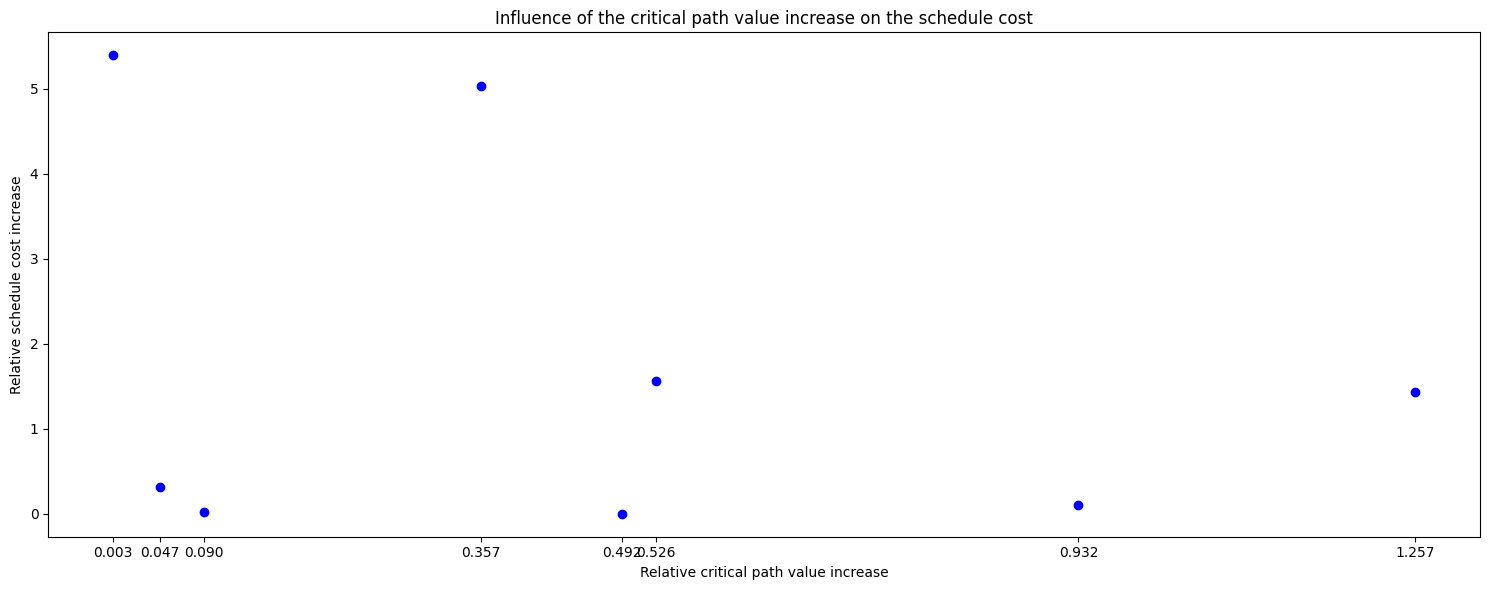

In [38]:
plot_cr_cpv_increase(cost_increases, selected_instances)

In [59]:
cost_increases = {workflow: measure_cost_overhead(workflow, "workflows_data/machines/linear_smaller_diff.json", 1/3) for workflow in selected_instances.keys()}

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel(R) Core(TM) i7-7700HQ CPU @ 2.80GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 458 rows, 1330 columns and 5170 nonzeros
Model fingerprint: 0x430cdde0
Variable types: 0 continuous, 1330 integer (1330 binary)
Coefficient statistics:
  Matrix range     [3e-01, 1e+03]
  Objective range  [5e-01, 3e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+03]
Found heuristic solution: objective 149633.71661
Presolve removed 384 rows and 1148 columns
Presolve time: 0.01s
Presolved: 74 rows, 182 columns, 512 nonzeros
Found heuristic solution: objective 107057.83810
Variable types: 0 continuous, 182 integer (182 binary)

Root relaxation: objective 1.065835e+05, 19 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumb

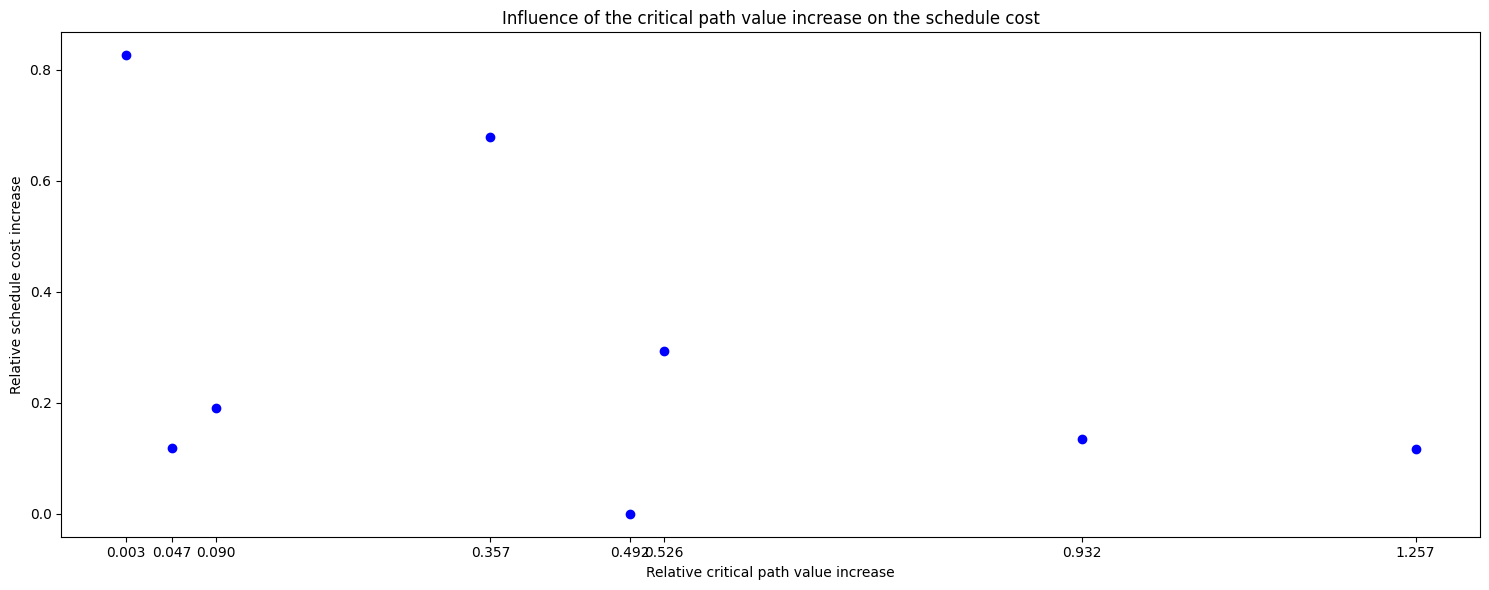

In [69]:
plot_cr_cpv_increase(cost_increases, selected_instances)

In [16]:
def measure_cost_overhead_cpv_mult(tasks_file, machines_file, subraph_size_divisor=4, cpv_mult = 1.1):
    workflow = Workflow(tasks_file, machines_file, 100000)
    deadline = int(workflow.critical_path_value * cpv_mult)
    solver = get_solver(tasks_file, machines_file, deadline)
    sp_solver = get_decomposed_solver(tasks_file, machines_file, deadline, workflow.wf_instance.workflow.number_of_nodes() // subraph_size_divisor)
    workflow_schedule = solver.solve()
    sp_workflow_schedule = sp_solver.solve()
    return sp_workflow_schedule.cost/workflow_schedule.cost

In [72]:
cost_increases_cpv_mult = {workflow: measure_cost_overhead_cpv_mult(workflow, "workflows_data/machines/linear_smaller_diff.json", subraph_size_divisor=1/3, cpv_mult=1.1) for workflow in selected_instances.keys()}

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)
CPU model: Intel(R) Core(TM) i7-7700HQ CPU @ 2.80GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 458 rows, 1330 columns and 5170 nonzeros
Model fingerprint: 0x88164df1
Variable types: 0 continuous, 1330 integer (1330 binary)
Coefficient statistics:
  Matrix range     [3e-01, 1e+03]
  Objective range  [5e-01, 3e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+03]
Found heuristic solution: objective 149633.71661
Presolve removed 378 rows and 1129 columns
Presolve time: 0.01s
Presolved: 80 rows, 201 columns, 553 nonzeros
Found heuristic solution: objective 104842.10995
Variable types: 0 continuous, 201 integer (201 binary)

Root relaxation: objective 1.046453e+05, 13 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbe

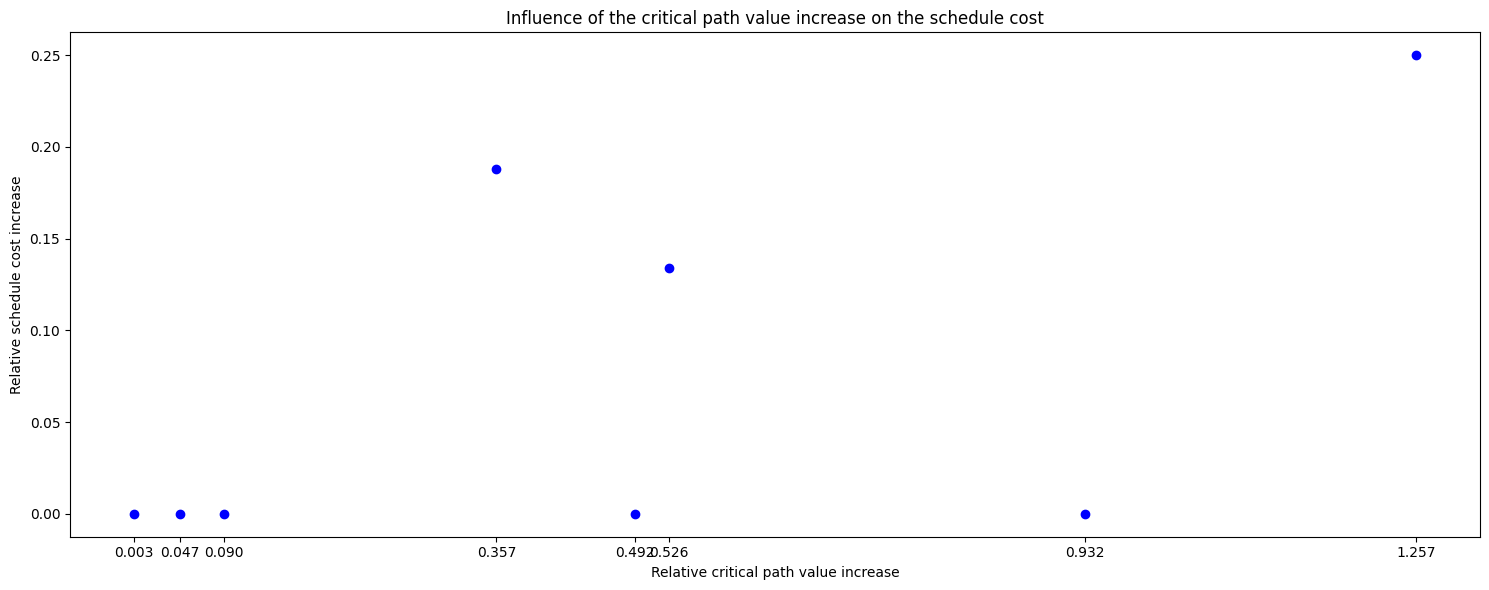

In [73]:
plot_cr_cpv_increase(cost_increases_cpv_mult, selected_instances)

# Experiment 2 - Scalability

In [17]:
class TreeMetrics():
    def __init__(self, tree:SPTreeNode):
        self.tree = tree
        
    def series_nodes_number(self):
        composition_nodes = self._composition_nodes()
        return len([n for n in composition_nodes if n.operation == Composition.SERIES])

    def parallel_nodes_number(self):
        composition_nodes = self._composition_nodes()
        return len([n for n in composition_nodes if n.operation == Composition.PARALLEL])
    
    def _composition_nodes(self):
        return [n for n in PreOrderIter(self.tree) if isinstance(n, CompositionNode)]

def prune_tree(tree: SPTreeNode, max_graph_size: int):
    graph_nodes = tree.get_graph_nodes()
    if len(graph_nodes) <= max_graph_size:
        tree.children = []
        return tree
    elif tree.is_leaf:
        raise ValueError(f"Demanded max graph size is {max_graph_size}, \
                but graph containing {len(graph_nodes)} nodes can't be divided further")
    else:
        [prune_tree(child, max_graph_size) for child in tree.children]
        return tree

In [18]:
tasks_file = "/home/marcin/Programming/pegasus-instances/epigenomics/chameleon-cloud/epigenomics-chameleon-hep-1seq-100k-001.json"
machines_file = "workflows_data/machines/linear.json"
deadline = 100000
workflow = Workflow(tasks_file, machines_file, deadline)
print(workflow.critical_path_value)

552.366656896


In [19]:
workflow = Workflow(tasks_file, machines_file, 560)

In [20]:
def measure_mss_influence(tasks_file, machines_file, deadline, mss:int):
    workflow = Workflow(tasks_file, machines_file, deadline)
    sp_workflow = SeriesParallelSplit().create_sp_workflow(workflow)
    tree: SPTreeNode = get_sp_decomposition_tree(sp_workflow.wf_instance.workflow)
    pruned_tree: SPTreeNode = prune_tree(tree, mss)
    tree_metrics = TreeMetrics(pruned_tree)
    solver = get_solver(tasks_file, machines_file, deadline)
    sp_solver = get_decomposed_solver(tasks_file, machines_file, deadline, mss)
    workflow_schedule = solver.solve()
    sp_workflow_schedule = sp_solver.solve()
    return (tree_metrics, sp_workflow_schedule.cost/workflow_schedule.cost)

In [21]:
tasks_file = "/home/marcin/Programming/pegasus-instances/epigenomics/chameleon-cloud/epigenomics-chameleon-hep-1seq-100k-001.json"
machines_file = "workflows_data/machines/linear.json"
deadline = 560
mss = np.linspace(2, 41, 8, dtype=int)

In [116]:
mss

array([ 6, 13, 20, 27, 34, 41])

In [22]:
measure_mss_influence(tasks_file, machines_file, deadline, 2)

Set parameter Username
Academic license - for non-commercial use only - expires 2024-11-12
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel(R) Core(TM) i7-7700HQ CPU @ 2.80GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 50 rows, 205 columns and 610 nonzeros
Model fingerprint: 0x0d83383d
Variable types: 0 continuous, 205 integer (205 binary)
Coefficient statistics:
  Matrix range     [4e-01, 7e+02]
  Objective range  [2e+00, 3e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 6e+02]
Found heuristic solution: objective 20897.225798
Presolve removed 0 rows and 49 columns
Presolve time: 0.00s
Presolved: 50 rows, 156 columns, 471 nonzeros
Variable types: 0 continuous, 156 integer (156 binary)
Found heuristic solution: objective 13337.157370

Root relaxation: objective 1.227348e+04, 20 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node   

(<__main__.TreeMetrics at 0x7fdac7468450>, 1.320384485134138)

In [23]:
results = {max_subgraph_size: measure_mss_influence(tasks_file, machines_file, deadline, max_subgraph_size) for max_subgraph_size in mss}

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)
CPU model: Intel(R) Core(TM) i7-7700HQ CPU @ 2.80GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 50 rows, 205 columns and 610 nonzeros
Model fingerprint: 0x0d83383d
Variable types: 0 continuous, 205 integer (205 binary)
Coefficient statistics:
  Matrix range     [4e-01, 7e+02]
  Objective range  [2e+00, 3e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 6e+02]
Found heuristic solution: objective 20897.225798
Presolve removed 0 rows and 49 columns
Presolve time: 0.00s
Presolved: 50 rows, 156 columns, 471 nonzeros
Variable types: 0 continuous, 156 integer (156 binary)
Found heuristic solution: objective 13337.157370

Root relaxation: objective 1.227348e+04, 20 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    Bes

In [24]:
def plot_mss_influence(mss, cr):  
    fig, ax = plt.subplots(1, 1, figsize=(15,6))
    
    ax.scatter(mss, cr, color='blue')
    ax.set_xticks(mss)
    ax.set_xlabel('max subgraph size')
    ax.set_ylabel('Relative schedule cost increase')
    ax.set_title('Influence of the max subgraph size on the schedule cost')
    
    plt.tight_layout()
    plt.show()

In [25]:
max_subgraph_sizes = []
crs = []
series_nodes_count = []
for max_subgraph_size, result in results.items():
    max_subgraph_sizes.append(max_subgraph_size)
    metrics, cr = result
    crs.append(cr)
    series_nodes_count.append(metrics.series_nodes_number())

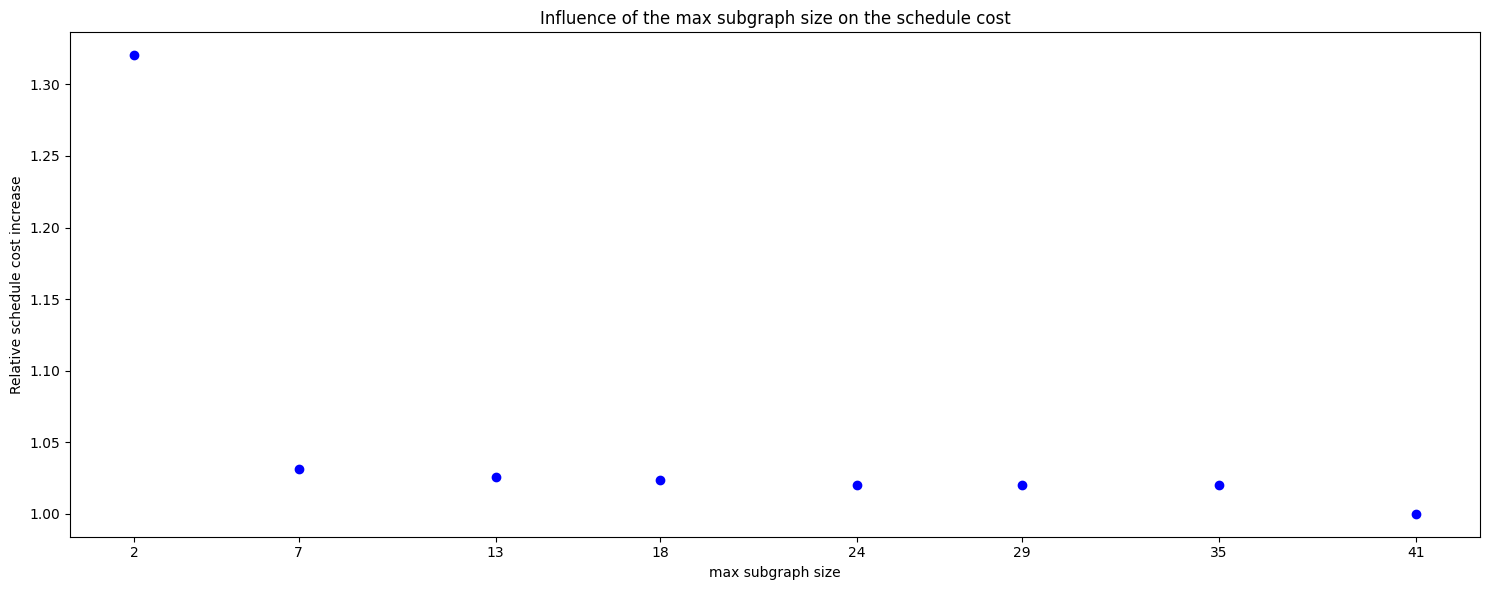

In [26]:
plot_mss_influence(max_subgraph_sizes, crs)